# Création de clusters/régions avec KMeans

On affiche les régions, par exemple les eaux pour vérifier que les régions sont correctes. Ces régions ont été faites avec KMeans

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import IntSlider, interact
from shapely import wkt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [149]:
# Load the data
gdf = gpd.read_file('processed_data/swiss_data_all_with_temp.csv')
gdf.drop(columns=["field_1"], inplace=True)
gdf.head()

,idx,geometry,altitude,TypoCH_NUM,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI,mean_annual_temp
0,264,"POLYGON ((2486071.58 1112261.72, 2487071.58 11...",374.268,82.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,10.4
1,265,"POLYGON ((2486071.58 1113261.72, 2487071.58 11...",411.3956,12.0,"orthic Luvisol; eutric, calcaric Cambisol",4.0,6.0,4.0,10.100000000000001
2,269,"POLYGON ((2486071.58 1117261.72, 2487071.58 11...",461.3668,62.0,"eutric, gleyic, dystric, calcaric Cambisol; or...",5.0,4.0,6.0,9.700000000000001
3,270,"POLYGON ((2486071.58 1118261.72, 2487071.58 11...",470.4324,82.0,"eutric, gleyic, dystric, calcaric Cambisol; or...",5.0,4.0,6.0,9.8
4,490,"POLYGON ((2487071.58 1112261.72, 2488071.58 11...",381.006,82.0,"eutric Fluvisol; gleyic, eutric, calcaric Camb...",5.0,4.0,5.0,10.4


In [150]:
# Add x and y columns to the GeoDataFrame
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)

In [151]:
# Réccupérer les coordonnées x et y du premier point de chaque polygone
gdf['x'] = None
gdf['y'] = None

for idx, row in gdf.iterrows():
    polygon = row['geometry']
    x, y = polygon.exterior.xy
    gdf.at[idx, 'x'] = x[0]
    gdf.at[idx, 'y'] = y[0]

In [152]:
# Affecte les bons type aux colonnes
gdf['altitude'] = gdf['altitude'].astype(float)
gdf['TypoCH_NUM'] = gdf['TypoCH_NUM'].astype(float)
gdf['NAHRSTOFF'] = gdf['NAHRSTOFF'].astype(float)
gdf['WASSERDURC'] = gdf['WASSERDURC'].astype(float)
gdf['WASSERSPEI'] = gdf['WASSERSPEI'].astype(float)
gdf['mean_annual_temp'] = gdf['mean_annual_temp'].astype(float)


# Drop the geometry column
gdf = gdf.drop(columns='geometry')

In [153]:
# Étape 1 : Fractionner les chaînes de caractères en listes
gdf['Bodentyp_split'] = gdf['Bodentyp'].str.split('; ')

# Étape 2 : Identifier tous les mots uniques
all_labels = set(label.strip() for sublist in gdf['Bodentyp_split'] for label in sublist)

# Étape 3 : Créer des colonnes dummies
for label in all_labels:
    gdf["Bodentyp_"+label] = gdf['Bodentyp_split'].apply(lambda x: label in x)

# Supprimer la colonne temporaire si nécessaire
gdf = gdf.drop(columns=['Bodentyp_split'])
gdf = gdf.drop(columns=['Bodentyp'])
gdf = gdf.drop(columns=['idx'])

In [154]:
# Dummies TypoCH_NUM, NAHRSTOFF, WASSERDURC et WASSERSPEI
gdf = pd.get_dummies(gdf, columns=['TypoCH_NUM', 'NAHRSTOFF', 'WASSERDURC', 'WASSERSPEI'])

In [155]:
# Normalisation des données numériques

scaler = StandardScaler()

gdf[['altitude', 'x', 'y', 'mean_annual_temp']] = scaler.fit_transform(gdf[['altitude', 'x', 'y', 'mean_annual_temp']])

In [156]:
gdf.head()

,altitude,mean_annual_temp,x,y,"Bodentyp_eutric, gleyic, dystric, calcaric Cambisol",Bodentyp_Lithosol,Bodentyp_spododystric Cambisol,Bodentyp_Rendzina (Jura),"Bodentyp_mollic, humic Gleysol",Bodentyp_humic Cambisol,...,WASSERDURC_4.0,WASSERDURC_5.0,WASSERDURC_6.0,WASSERSPEI_-9999.0,WASSERSPEI_1.0,WASSERSPEI_2.0,WASSERSPEI_3.0,WASSERSPEI_4.0,WASSERSPEI_5.0,WASSERSPEI_6.0
0,-1.163745,1.305174,-2.246361,-1.494539,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
1,-1.117269,1.233019,-2.246361,-1.473620,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
2,-1.054716,1.136813,-2.246361,-1.389942,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,-1.043368,1.160864,-2.246361,-1.369023,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,-1.155310,1.305174,-2.233447,-1.494539,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False


In [157]:
#Remove x and y columns to clustering
gdfWithoutCoordinate = gdf.drop(columns=['x', 'y'])

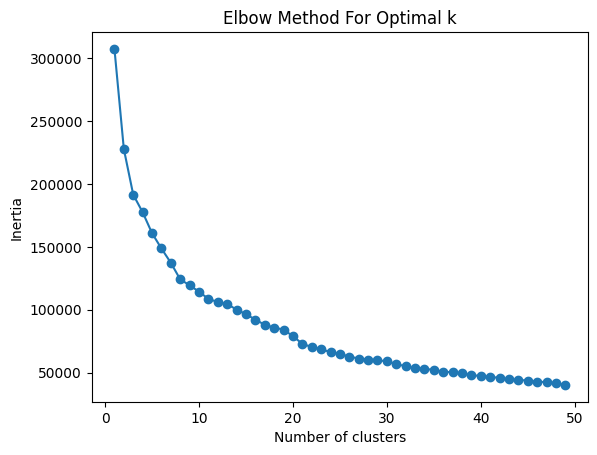

In [158]:
# Get best number of clusters

# Calculate the sum of squared distances for K values in the range 1 to 15
inertia = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(gdfWithoutCoordinate)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.plot(range(1, 50), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

Nous avons choisi de faire 30 groupes

In [159]:
kmeans = KMeans(n_clusters=30)
kmeansError = kmeans.fit_transform(gdfWithoutCoordinate)

gdf['cluster'] = kmeans.labels_
gdf['erreur'] = np.min(kmeansError,1)

(array([2.230e+02, 4.780e+02, 5.440e+02, 7.720e+02, 1.298e+03, 9.830e+02,
        7.520e+02, 5.640e+02, 7.000e+02, 9.890e+02, 8.100e+02, 1.364e+03,
        9.100e+02, 1.096e+03, 1.095e+03, 9.690e+02, 7.960e+02, 7.370e+02,
        7.690e+02, 1.320e+03, 8.470e+02, 6.490e+02, 8.340e+02, 8.950e+02,
        9.690e+02, 8.940e+02, 6.800e+02, 1.015e+03, 1.054e+03, 1.169e+03,
        1.053e+03, 8.890e+02, 8.450e+02, 8.630e+02, 9.680e+02, 5.740e+02,
        4.930e+02, 5.080e+02, 6.820e+02, 7.540e+02, 5.060e+02, 4.670e+02,
        6.680e+02, 4.880e+02, 4.470e+02, 4.200e+02, 3.750e+02, 3.450e+02,
        3.450e+02, 2.810e+02, 3.020e+02, 2.670e+02, 2.630e+02, 2.360e+02,
        1.750e+02, 1.550e+02, 1.730e+02, 1.170e+02, 1.000e+02, 1.850e+02,
        1.550e+02, 1.270e+02, 1.960e+02, 1.110e+02, 1.170e+02, 1.020e+02,
        7.000e+01, 5.800e+01, 6.300e+01, 8.600e+01, 9.400e+01, 7.900e+01,
        4.300e+01, 3.400e+01, 3.500e+01, 3.900e+01, 2.900e+01, 3.000e+01,
        2.400e+01, 2.100e+01, 1.500e+0

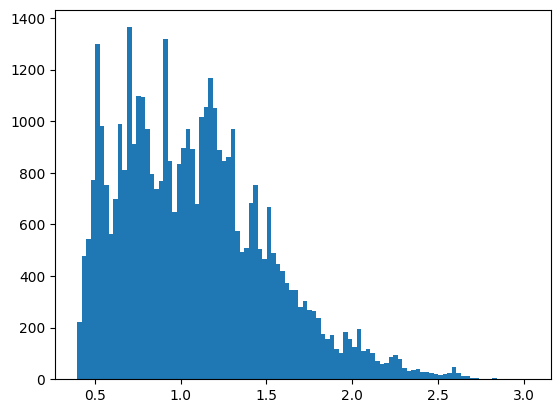

In [160]:
plt.hist(gdf['erreur'], bins=100)
plt.show()

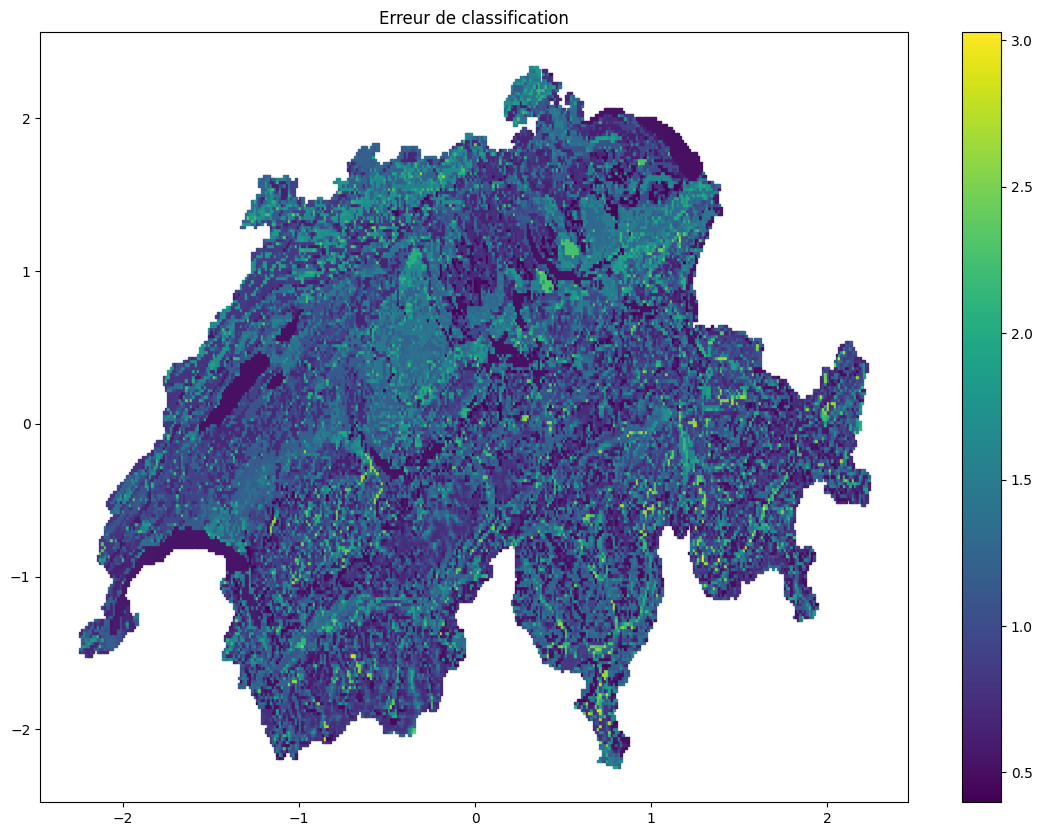

In [161]:
# plot clusters

squareSize = 2.5

plt.figure(figsize=(14, 10))

plt.scatter(gdf['x'], gdf['y'], c=gdf['erreur'], cmap='viridis', marker='s', s=squareSize)
plt.title('Erreur de classification')
plt.colorbar()
plt.show()


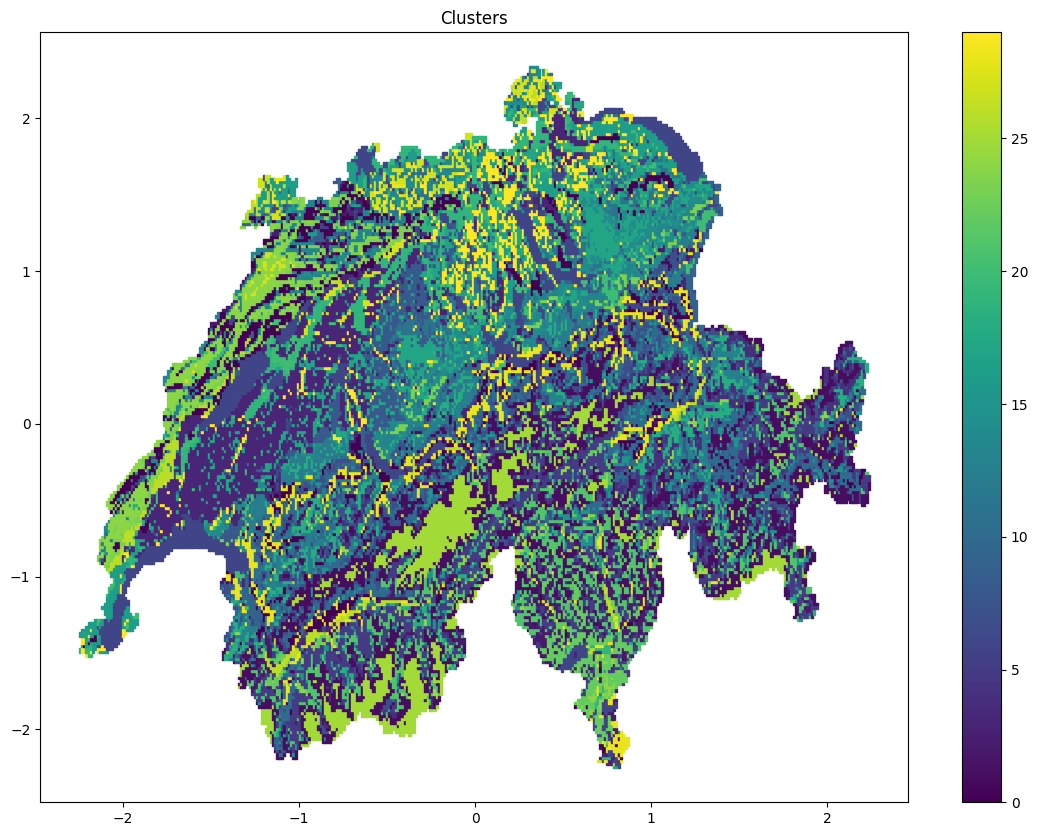

In [162]:
#PLOT DES CLUSTER
plt.figure(figsize=(14, 10))
plt.scatter(gdf['x'], gdf['y'], c=gdf['cluster'], cmap='viridis', marker='s', s=squareSize)
plt.title('Clusters')
plt.colorbar()
plt.show()


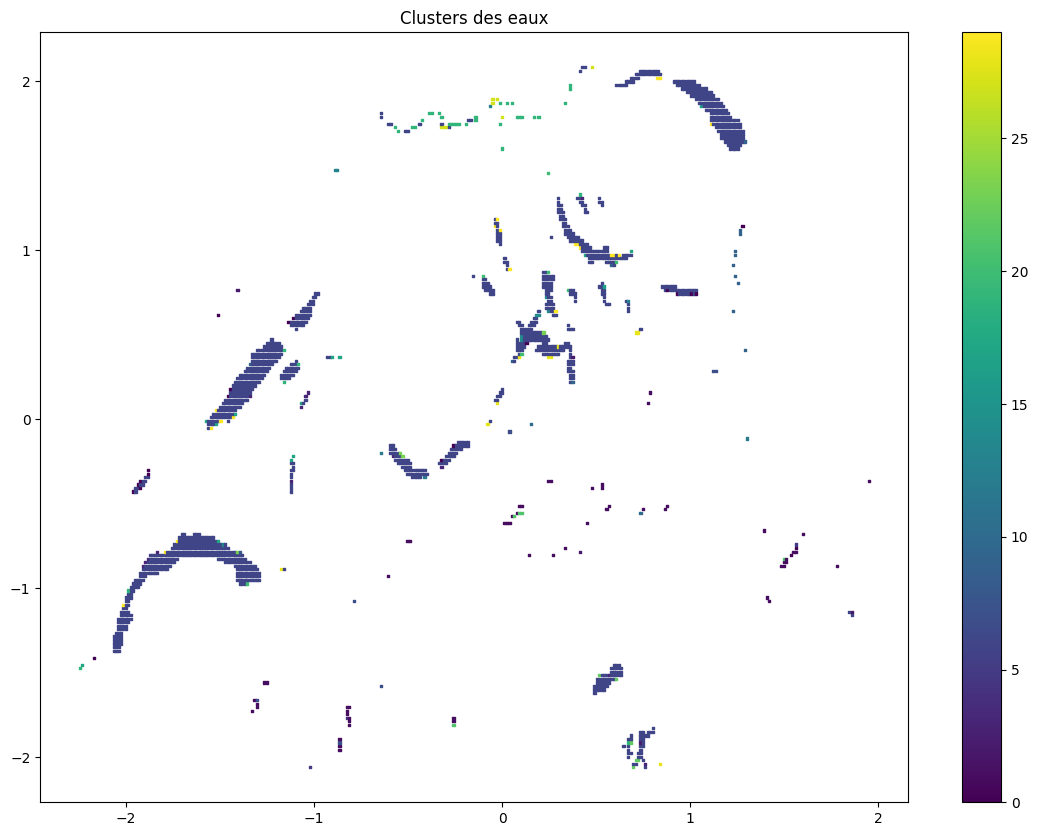

In [163]:
#PLOT DES CLUSTER POUR LES EAUX
gdfLake = gdf[(gdf['TypoCH_NUM_11.0'] == 1) | (gdf['TypoCH_NUM_12.0'] == 1)]

plt.figure(figsize=(14, 10))
plt.scatter(gdfLake['x'], gdfLake['y'], c=gdfLake['cluster'], cmap='viridis', marker='s', s=squareSize)
plt.title('Clusters des eaux')
plt.colorbar()
plt.show()

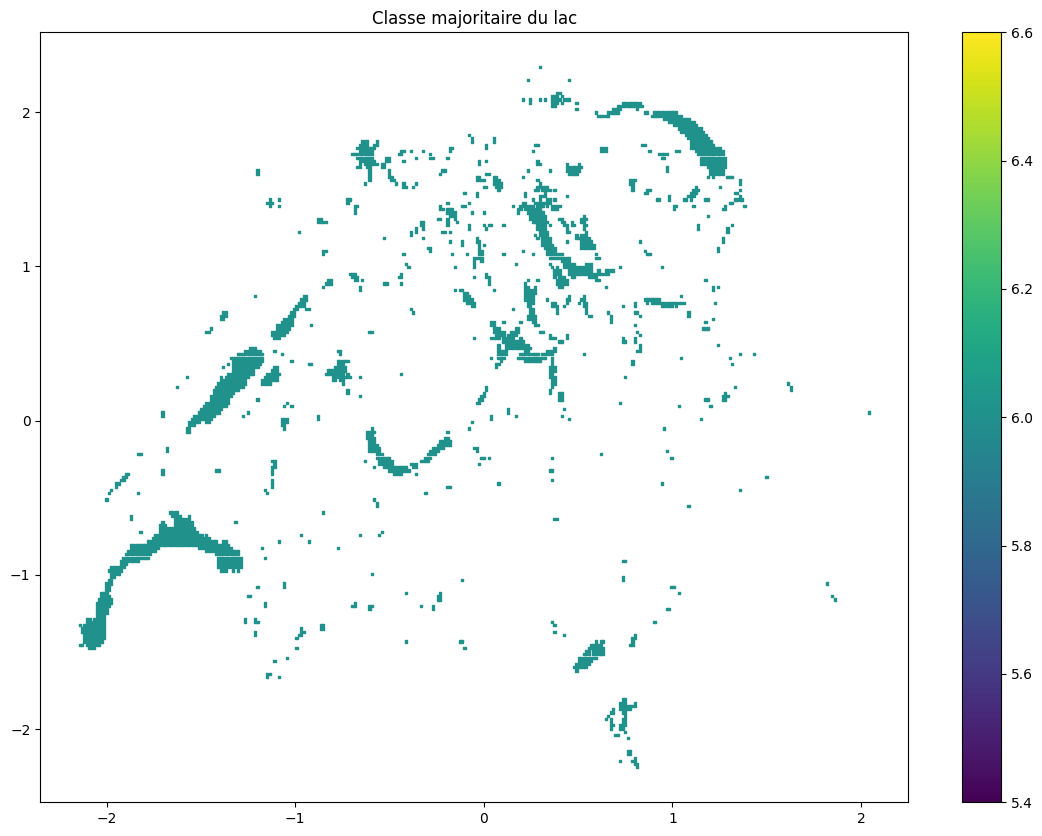

In [164]:
#PLOT DE LA CLASSE CORRESPONDANT MAJORITAIREMENT AU LAC
lakeCluster = gdfLake["cluster"].median()
gdfLakeCluster = gdf[gdf['cluster'] == lakeCluster]

plt.figure(figsize=(14, 10))
plt.scatter(gdfLakeCluster['x'], gdfLakeCluster['y'], c=gdfLakeCluster['cluster'], cmap='viridis', marker='s', s=squareSize)
plt.title('Classe majoritaire du lac')
plt.colorbar()
plt.show()


In [165]:
# Calcul des limites pour une échelle uniforme
x_min, x_max = gdf['x'].min(), gdf['x'].max()
y_min, y_max = gdf['y'].min(), gdf['y'].max()

# Fonction pour tracer les clusters
def plot_cluster(val):
    gdfSigleCluster = gdf[gdf['cluster'] == val]
    plt.figure(figsize=(6, 6))
    plt.scatter(gdfSigleCluster['x'], gdfSigleCluster['y'], 
                c=gdfSigleCluster['cluster'], cmap='viridis', 
                marker='s', s=squareSize)
    plt.title(f'Cluster: {val}')
    plt.xlim(x_min, x_max)  # Appliquer les limites X
    plt.ylim(y_min, y_max)  # Appliquer les limites Y
    plt.show()

# Curseur interactif
interact(plot_cluster, val=IntSlider(min=gdf['cluster'].min(), 
                                     max=gdf['cluster'].max(), 
                                     step=1, 
                                     value=gdf['cluster'].min()))


interactive(children=(IntSlider(value=0, description='val', max=29), Output()), _dom_classes=('widget-interact…

<function __main__.plot_cluster(val)>

In [ ]:
# Export data
tmp = gpd.read_file('processed_data/swiss_data_all_with_temp.csv')
tmp.drop(columns=["field_1"], inplace=True)

tmp["region"] = gdf["cluster"]

tmp.to_csv('processed_data/swiss_data_all_with_temp_region.csv', index=False)